# Computational Social Science Project #3 

*Group members:* Paige Park 

*Semester:* Fall 2023

In [18]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb              # for xgboost
import arviz as az                 # ArviZ is a Python package for exploratory analysis of Bayesian models
import pymc as pm                  # PyMC (formerly PyMC3) is a Python package for Bayesian statistical modeling
import pymc_bart as pmb            # PyMC-BART extends PyMC 
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression # for logisitc reg
from sklearn.ensemble import RandomForestClassifier

In [98]:
# Inspections Data 2011 - 2013
chicago_inspections_2011_to_2013 = pd.read_csv("data/Chicago Inspections 2011-2013.csv", 
                                              low_memory=False)

In [20]:
# Look at the inspections data
chicago_inspections_2011_to_2013.head()

,Inspection_ID,Inspection_Date,DBA_Name,AKA_Name,License,Facility_Type,Risk,Address,City,State,Zip,Inspection_Type,Results,Latitude,Longitude,Location,Facility_Type_Clean,criticalCount,seriousCount,minorCount,pass_flag,fail_flag,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,ID,LICENSE_ID,ACCOUNT_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,BUSINESS_ACTIVITY_ID,BUSINESS_ACTIVITY,LICENSE_NUMBER,APPLICATION_TYPE,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_STATUS,LATITUDE,LONGITUDE,minDate,maxDate,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound
0,269961,2013-01-31,SEVEN STAR,SEVEN STAR,30790,Grocery Store,Risk 3 (Low),3352 N BROADWAY,CHICAGO,IL,60657.0,Canvass,Pass,41.943359,-87.644999,"(41.943359344775146, -87.64499875300952)",Other,0,0,2,1,0,0,0,0,0,2.0,1,30790-20110416,2081412.0,63759.0,VIRGINIA DELA ROSA,SEVEN STAR,3352 N BROADWAY 1,CHICAGO,IL,60657.0,44.0,33.0,44-33,19.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,30790.0,RENEW,2011-04-16,2013-04-15,AAI,41.943359,-87.644999,2002-02-16,2015-04-15,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0
1,507211,2011-10-18,PANERA BREAD,PANERA BREAD,1475890,Restaurant,Risk 1 (High),6059 N LINCOLN AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.991919,-87.709631,"(41.99191947239194, -87.70963133440333)",Restaurant,0,0,3,1,0,0,0,0,0,2.0,1,1475890-20110416,2081695.0,207283.0,"PANERA, LLC",PANERA BREAD,6059 N LINCOLN AVE C,CHICAGO,IL,60659.0,50.0,23.0,50-23,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1475890.0,RENEW,2011-04-16,2013-04-15,AAI,41.991919,-87.709631,2004-05-05,2019-04-15,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0
2,507212,2011-10-18,LITTLE QUIAPO RESTAURANT,LITTLE QUIAPO RESTAURANT,1740130,Restaurant,Risk 1 (High),6259 N MCCORMICK RD,CHICAGO,IL,60659.0,Canvass,Fail,41.995632,-87.712707,"(41.99563177556418, -87.71270678169132)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1740130-20110216,2070145.0,3107.0,ENELITA GARCIA,LITTLE QUIAPO RESTAURANT,6259 N MCCORMICK RD,CHICAGO,IL,60659.0,50.0,25.0,50-25,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1740130.0,RENEW,2011-02-16,2013-02-15,AAI,41.995632,-87.712707,2007-03-22,2017-02-15,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0
3,507216,2011-10-19,SERGIO'S TAQUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA,1447363,Restaurant,Risk 1 (High),3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.982933,-87.710982,"(41.982933189164974, -87.71098225381141)",Restaurant,0,0,6,1,0,0,0,0,0,2.0,1,1447363-20110216,2071895.0,270993.0,SERGIO'S TAZUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA INC.,3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,39.0,48.0,39-48,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1447363.0,RENEW,2011-02-16,2013-02-15,AAI,41.982933,-87.710982,2003-12-31,2019-02-15,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0
4,507219,2011-10-20,TARGET STORE # T-2079,TARGET,1679459,Restaurant,Risk 2 (Medium),2112 W PETERSON AVE,CHICAGO,IL,60659.0,Canvass,Fail,41.990729,-87.682979,"(41.99072921796059, -87.68297945359863)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1679459-20100216,2009972.0,15538.0,TARGET CORPORATION,TARGET STORE # T-2079,2112 W PETERSON AVE,CHICAGO,IL,60659.0,40.0,18.0,40-18,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1679459.0,RENEW,

In [21]:
# List column names
chicago_inspections_2011_to_2013.columns

Index(['Inspection_ID', 'Inspection_Date', 'DBA_Name', 'AKA_Name', 'License',
       'Facility_Type', 'Risk', 'Address', 'City', 'State', 'Zip',
       'Inspection_Type', 'Results', 'Latitude', 'Longitude', 'Location',
       'Facility_Type_Clean', 'criticalCount', 'seriousCount', 'minorCount',
       'pass_flag', 'fail_flag', 'pastFail', 'pastCritical', 'pastSerious',
       'pastMinor', 'timeSinceLast', 'firstRecord', 'ID', 'LICENSE_ID',
       'ACCOUNT_NUMBER', 'LEGAL_NAME', 'DOING_BUSINESS_AS_NAME', 'ADDRESS',
       'CITY', 'STATE', 'ZIP_CODE', 'WARD', 'PRECINCT', 'WARD_PRECINCT',
       'POLICE_DISTRICT', 'LICENSE_CODE', 'LICENSE_DESCRIPTION',
       'BUSINESS_ACTIVITY_ID', 'BUSINESS_ACTIVITY', 'LICENSE_NUMBER',
       'APPLICATION_TYPE', 'LICENSE_TERM_START_DATE',
       'LICENSE_TERM_EXPIRATION_DATE', 'LICENSE_STATUS', 'LATITUDE',
       'LONGITUDE', 'minDate', 'maxDate', 'ageAtInspection',
       'consumption_on_premises_incidental_activity', 'tobacco',
       'package_goods',

In [22]:
# Drop column names related to geography, identification, and pass/fail flags that perfectly predict the outcome
chicago_inspections_2011_to_2013.drop(columns = ['AKA_Name', 
                                                 'License',
                                                'Address',
                                                'City',
                                                'State',
                                                'Zip',
                                                'Latitude',
                                                'Longitude',
                                                'Location',
                                                'ID',
                                                'LICENSE_ID',
                                                 'LICENSE_TERM_START_DATE',
                                                 'LICENSE_TERM_EXPIRATION_DATE',
                                                 'LICENSE_STATUS',
                                                'ACCOUNT_NUMBER',
                                                'LEGAL_NAME',
                                                'DOING_BUSINESS_AS_NAME',
                                                'ADDRESS',
                                                'CITY',
                                                'STATE',
                                                'ZIP_CODE',
                                                'WARD',
                                                'PRECINCT',
                                                'LICENSE_CODE',
                                                'BUSINESS_ACTIVITY_ID',
                                                'BUSINESS_ACTIVITY',
                                                'LICENSE_NUMBER',
                                                'LATITUDE',
                                                'LONGITUDE',
                                                'pass_flag',
                                                'fail_flag'],
                                     inplace = True)

chicago_inspections_2011_to_2013.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

In [23]:
# Convert the Inspection Date to a datetime format
chicago_inspections_2011_to_2013['Inspection_Date'] = pd.to_datetime(chicago_inspections_2011_to_2013['Inspection_Date'], infer_datetime_format=True)  

## Visualization

What do inspections look like over time?

<Axes: title={'center': 'Inspections by Month and Year'}, xlabel='Inspection_MonthYear'>

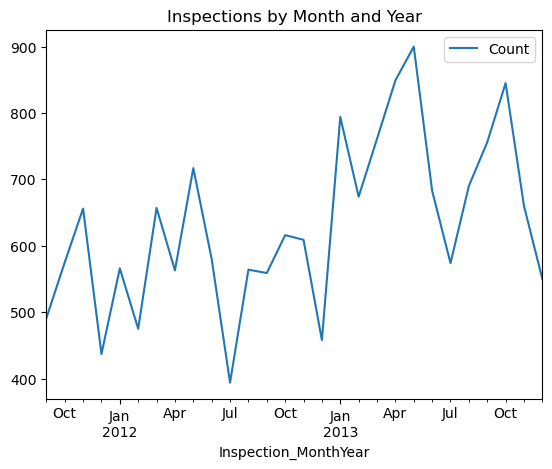

In [24]:
# Visualize Inspections Over Time
chicago_inspections_2011_to_2013['Inspection_MonthYear'] = chicago_inspections_2011_to_2013['Inspection_Date'].dt.to_period('M')
counts_by_day = chicago_inspections_2011_to_2013.groupby('Inspection_MonthYear').count().rename(columns = {'Facility_Type': 'Count'})['Count'].reset_index()
counts_by_day.set_index(["Inspection_MonthYear"], inplace = True)
counts_by_day.plot(title = "Inspections by Month and Year") 

What do the results look like? 

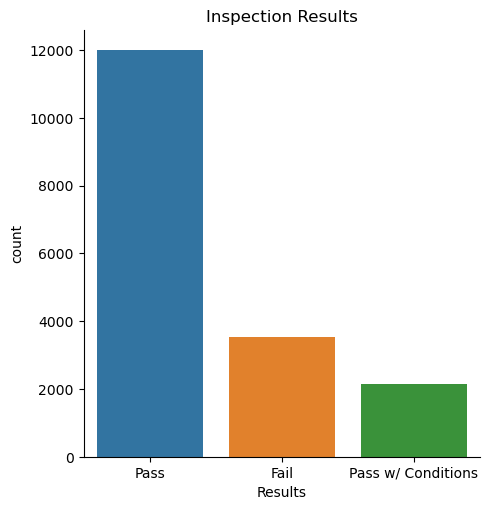

In [25]:
# Inspection Results
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count")

plt.title("Inspection Results")
plt.show()

What if we separate by facility type?

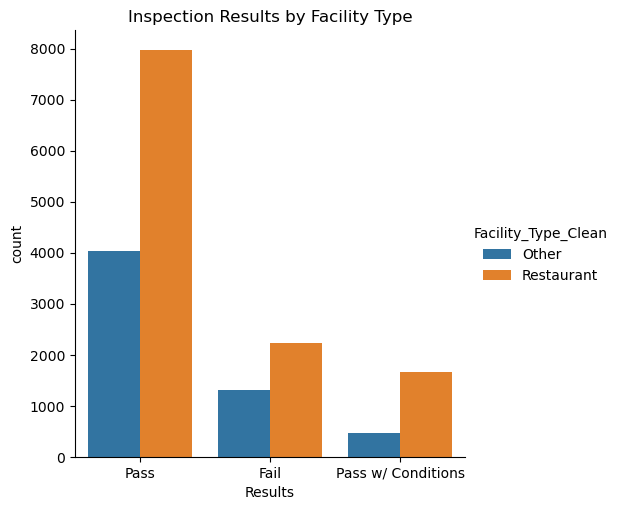

In [26]:
# Inspection Results by Facility Type (Restaurant or Not)
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count",
           hue = 'Facility_Type_Clean')

plt.title("Inspection Results by Facility Type")
plt.show()

## Preprocess Data

In [27]:
# Drop datetime info
chicago_inspections_2011_to_2013 = chicago_inspections_2011_to_2013.dropna().drop(['Inspection_Date',
                                      'minDate',
                                      'maxDate',
                                      'Inspection_MonthYear'],
                                      axis = 1)

In [28]:
# Set target variable. 
y = chicago_inspections_2011_to_2013['Results']
## Comment out the following code if you don't want to binarize the target variable
y = y.replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
y = lb_style.fit_transform(y)
# Recode 0s and 1s so 1s are "Fail"
y = np.where(y == 1, 0 ,1)

# process features
# -----------

# create feature dataset
X = chicago_inspections_2011_to_2013.drop(columns = ['Results', 
                                                     'Facility_Type', 
                                                     'LICENSE_DESCRIPTION', 
                                                     'WARD_PRECINCT'])


# get dummies
X = pd.get_dummies(X)

In [51]:
X.head()

,,criticalCount,seriousCount,minorCount,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,POLICE_DISTRICT,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound,Risk_Risk 1 (High),Risk_Risk 2 (Medium),Risk_Risk 3 (Low),Inspection_Type_Canvass,Facility_Type_Clean_Other,Facility_Type_Clean_Restaurant,APPLICATION_TYPE_C_EXPA,APPLICATION_TYPE_C_LOC,APPLICATION_TYPE_ISSUE,APPLICATION_TYPE_RENEW
Inspection_ID,DBA_Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
269961,SEVEN STAR,0,0,2,0,0,0,0,2.0,1,19.0,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0,0,0,1,1,1,0,0,0,0,1
507211,PANERA BREAD,0,0,3,0,0,0,0,2.0,1,24.0,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0,1,0,0,1,0,1,0,0,0,1
507212,LITTLE QUIAPO RESTAURANT,0,2,6,0,0,0,0,2.0,1,17.0,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0,1,0,0,1,0,1,0,0,0,1
507216,SERGIO'S TAQUERIA PIZZA INC.,0,0,6,0,0,0,0,2.0,1,17.0,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0,1,0,0,1,0,1,0,0,0,1
507219,TARGET STORE # T-2079,0,2,6,0,0,0,0,2.0,1,24.0,5.290411,0,0,1,0,0,1,0,0,0,0,0,0,0.009987,52.730000,16.266667,0.690000,9.530785,3.401567,2.126788,0,0,1,0,1,0,1,0,0,0,1


## Data Splitting

I decided to use cross validation rather than splitting the data into training and validation sets. The cross validation is carried out during the hyperparameter tuning of each of the models included below. 

## Fit Models

### Model 1: Logistic Regression

Logistic regression models are one of the most widely used, classic statistical methods for classification. While quite simple and straightforward to use, logistic regression requires strong assumptions about the functional form of the data and often isn't nearly as flexible or accurate as the other methods we'll try (XGBoost and BART). However, for some types of problems, logistic regression can be the best choice. It can provide greater interpretability than some of the more accurate methods and if that's important for a given problem, it could be the better model to use. In our case, we might be very interested in the logistic model coefficients and confidence intervals so that we are quite clear on the relationships between features of businesses and their likelihood of passing or failing an audit. 

In [42]:
# set seed
np.random.seed(10)

# set parameter grid
param_grid = [
    {'penalty': ['l2'], 'solver': ['lbfgs']},
    {'penalty': ['l1'], 'solver': ['liblinear']}
]

# create a model
logit_reg = LogisticRegression(max_iter=4000)

# execute the grid search and fit to training data
logit_grid = GridSearchCV(logit_reg, 
                          param_grid, 
                          cv=3,
                          n_jobs=-1)
logit_grid.fit(X, y.ravel())

# choose best performing model
best_index = np.argmax(logit_grid.cv_results_["mean_test_score"])

In [43]:
# print results
print("Best parameters found: ", logit_grid.cv_results_["params"][best_index])
print(f"Best cross-validated accuracy: {logit_grid.best_score_:.4f}")

Best parameters found:  {'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validated accuracy: 0.9160


### Model 2: Random Forest

Random forests (and tree-based methods in general) can be much more flexible than logistic regression approaches. The random forest algorithm is a "bagging" approach, which creates bootstrapped samples of the original data, randomly selects features, and trains decision trees on B sample datasets. Predictions from these models are made by averaging predictions from all of the individual trees on unseen X. Because the basis of random forests are decision trees, non-linear and complex relationships between features and outcomes can be captured better by random forest methods than logistic regression. An analyst can also gain some limited interpretablilty through feature importance rankings, though these rankings don't provide coefficient values or uncertainty quantifcation as logistic model results can. However, random forests can be more computationally intensive than regression models. There are also more hyperparameters that benefit from tuning than there are in logistic models. If not properly tuned (which takes time and computational power), these models may not perform better than the logistic regression approach. Since we don't know much about the functional form here, and care less about interpretability and more about prediction, random forests could be a good choice.

In [32]:
# create a random forest classifier object
rf_classifier = RandomForestClassifier(random_state=10)

# define param grid
param_grid = {
    'max_depth': [4, 5],
    'n_estimators': [100, 200]
}

# initialize grid search object
rf_grid = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, verbose=2)

# fit grid search to data
rf_grid.fit(X, y.ravel())

# Print best parameters and best score
print("Best parameters found: ", rf_grid.best_params_)
print("Best score found: ", rf_grid.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=4, n_estimators=200; total time=   1.3s
[CV] END ......................max_depth=4, n_estimators=200; total time=   1.2s
[CV] END ......................max_depth=4, n_estimators=200; total time=   1.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=200; total time=   1.5s
[CV] END ......................max_depth=5, n_estimators=200; total time=   1.4s
[CV] END ......................max_depth=5, n_est

### Model 3: XGBoost

XGBoost is a boosted-tree approach that adds several advantages to the random forest method. Boosting is similar to bagging execpt rather than taking new samples of the data and copmuting new, unrelated decision trees, boosting uses successive information from each new tree to construct the next tree. Like random forests, XGBoost can handle complex relationships, provide feature importance information, and obtain high performance accuracy. XGBoost improves on random forests in its computational efficiency, it's better handling of missing data, and it's ability to specify its own objective function. It's regularization parameters also help to avoid overfitting. XGBoost has also historically performed very well in accuracy competitions. However, XGBoost has even more hyperparameters than random forests meaning there is a lot of tweaking required to significantly improve model performance. For this problem, XGBoost could be a great choice for this problem since it has all of the strengths of random forests, plus additional benefits. 

In [44]:
# initialize an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=10)

# define param grid
param_grid = {
    'max_depth': [4, 5],
    #'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
    # 'subsample': [0.5, 0.7, 1],
    # 'colsample_bytree': [0.5, 0.7, 1]
    # could add more here, but this is enough for now
}

# initialize grid search
xgb_grid = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, verbose=2)

# fit grid search to data
xgb_grid.fit(X, y)

# Print best parameters and best score
print("Best parameters found: ", xgb_grid.best_params_)
print("Best score found: ", xgb_grid.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_est

## Validation Metrics

**Hint**: Try writing a for loop to use [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to check for accuracy, precision, recall and f1 across all of your models.

As the metrics in the table show, the logistic regression model has the highest accuracy and F1 score and closely rivals XGBoost for highest recall. The random forest approach has the highest precision. In this context, we would want to prioritize recall. We care more about neglecting to audit establishments that will likely fail inspections (false negatives) than choosing to audit establishments that will pass (false positives). The consequences for auditing passing businesses are that some amount of the budget is wasted, while not auditing failing businesses could result in foodbourne ilness spreading or other serious health complications. Maximizing recall minimizes false negatives since it measures the proporition of positive cases (failures) that the model correctly identifies. Thus, focusing on recall can better help to avoid the worst outcomes, in this case potential public health catastrophes.

In [46]:
# cross_validate returns the accuracy score by default but you can change this with the "scoring" argument
scores = {}
models = [logit_grid.best_estimator_, rf_grid.best_estimator_, xgb_grid.best_estimator_]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
scoring = ['accuracy', 'precision', 'recall', 'f1']

for model,name in zip(models, model_names):
    cv_results = cross_validate(model,   # specify estimator 
                        X,               # specify X
                        y.ravel(),       # specify y
                        cv=5,
                        scoring=scoring,
                        verbose=0)    
    
    # create a dictonary for the scores 
    scores[name] = {metric: np.mean(cv_results['test_' + metric]) for metric in scoring}   

# transform dictonary into df
scores_df = pd.DataFrame(scores)

print(scores_df)


           Logistic Regression  Random Forest   XGBoost
accuracy              0.921102       0.901966  0.918751
precision             0.784658       0.803711  0.772754
recall                0.842924       0.682213  0.847445
f1                    0.811310       0.736009  0.807783


## Policy Simulation

### Interpretable Machine Learning

**Hint**: Use tools like feature importance plots and coefficient plots

Both feature importance and coeffiecient plots from all three models show that the "serious count" variable largely dominates the feature importance ranking, indicating that inspection outcome predictions are highly related to this variable. "Serious count" likely represents the number of times a business had a serious health code violation, suggesting that previous inspection results are the most predictive of future inspection results. Additional features that would have been useful in the prediction could be more detailed variables on facility type (this was in the original dataset, but we removed it because it was too detailed and led to issues with prediction on the test set), the frequency of inspections, and compliance with training and certification requirements. 

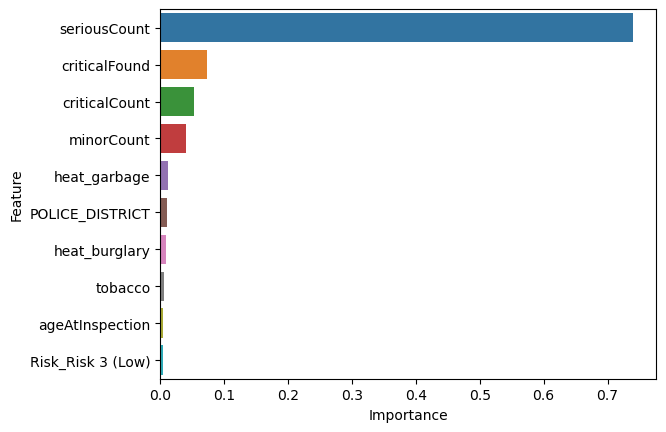

XGBoost


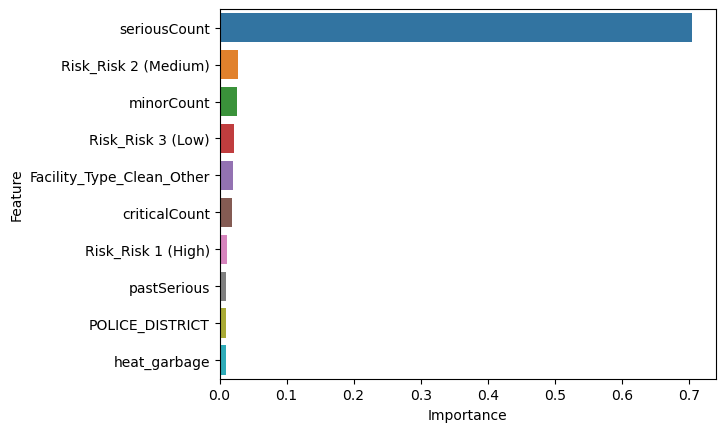

In [49]:
# feature importance plots

# random forest
feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(rf_grid.best_estimator_.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]

# plot 
sns.barplot(x = "Importance", 
            y = "Feature", 
            data = feat_importances.nlargest(10, 'Importance')) # identify the 10 most important features
plt.show()

# XGBoost
print("XGBoost")
feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(xgb_grid.best_estimator_.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]

# plot 
sns.barplot(x = "Importance", 
            y = "Feature", 
            
            data = feat_importances.nlargest(10, 'Importance')) # identify the 10 most important features
plt.show()



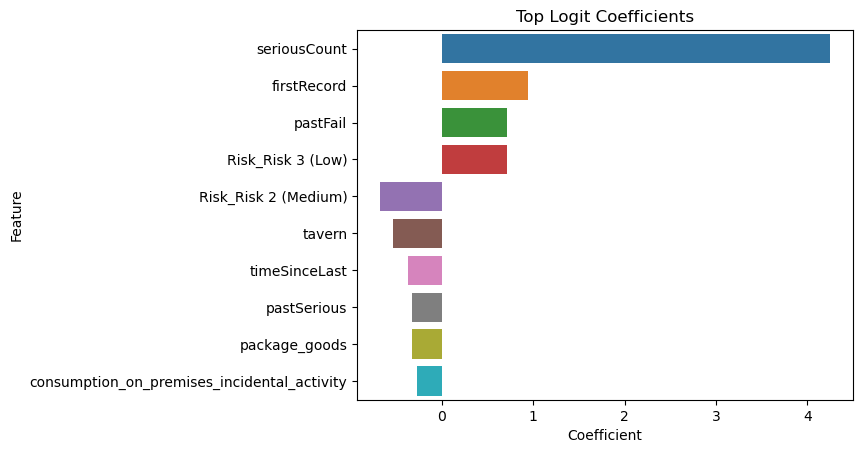

In [50]:
# coefficient plot

# extract the coefficents and create a dataframe for plotting 
logit_data = pd.concat([pd.DataFrame(X.columns),
                        pd.DataFrame(np.transpose(logit_grid.best_estimator_.coef_))],
                       axis = 1)

logit_data.columns = ['Feature', 'Coefficient']
logit_data['abs_coef'] = abs(logit_data['Coefficient'])

# plot 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=logit_data.nlargest(10, 'abs_coef')).set_title("Top Logit Coefficients")
plt.show()

## Prioritize Audits

**Hint**: Look up the [`.predict()`](https://www.kite.com/python/docs/sklearn.linear_model.SGDRegressor.predict), [`.predict_proba()`](https://www.kite.com/python/docs/sklearn.linear_model.LogisticRegression.predict_proba), and [`.sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) methods. Then: 





1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities. 

The validation results indicated that the logistic model performed best across almost all metrics for this dataset and closely rivaled XGBoost in the recall metric. I'll use logistic regression to predict outcomes and probabilities.

In [53]:
logit_model = logit_grid.best_estimator_
predictions = logit_model.predict(X)
probas = logit_model.predict_proba(X)

2. Order your audits by their probability of detecting a "Fail" score

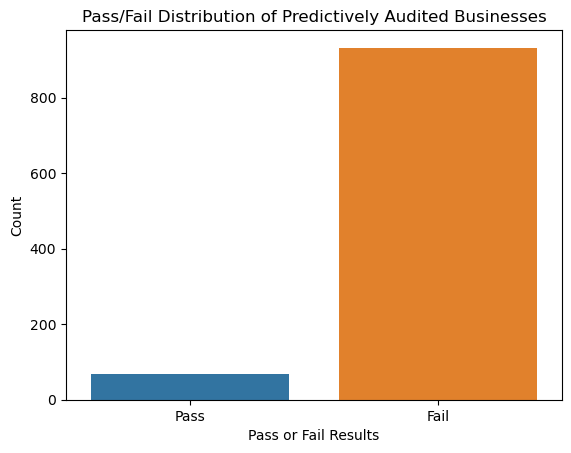

In [89]:
# extract probabilities for class 1 (represents a failed inspection)
class_1_probas = probas[:, 1]

# get sorted indices (from largest to smallest probability)
sorted_indices = np.argsort(class_1_probas)[::-1]

# reorder the observations by this sorting of indices 
sorted_X = X.iloc[sorted_indices]
sorted_y = y[sorted_indices]

# choose audits 
audits_X = sorted_X.iloc[0:1000]
audits_y = sorted_y[0:1000]
# print(audits['seriousCount'])

3. Plot your distribution of pass/fail among the first 1000 observations in the dataset

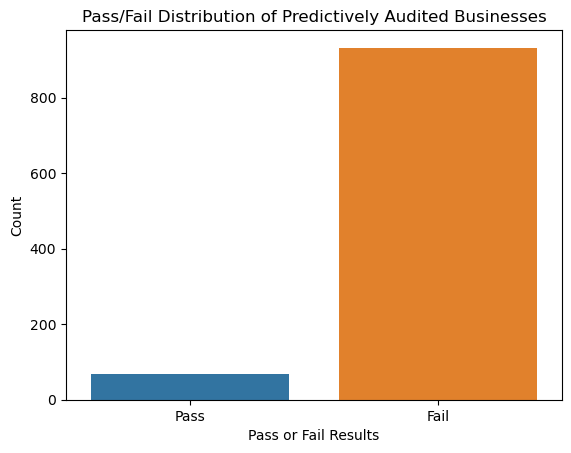

In [113]:
# Create a new DataFrame with labels
df = pd.DataFrame({'Inspection_Result': audits_y.ravel()})
df['Label'] = df['Inspection_Result'].map({0: 'Pass', 1: 'Fail'})

# plot
sns.countplot(x='Inspection_Result', data=df)

# setting labels and title for clarity
plt.xticks(ticks=[0, 1], labels=['Pass', 'Fail'])
plt.xlabel('Pass or Fail Results')
plt.ylabel('Count')
plt.title('Pass/Fail Distribution of Predictively Audited Businesses')
plt.show()

4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1000 observations at random

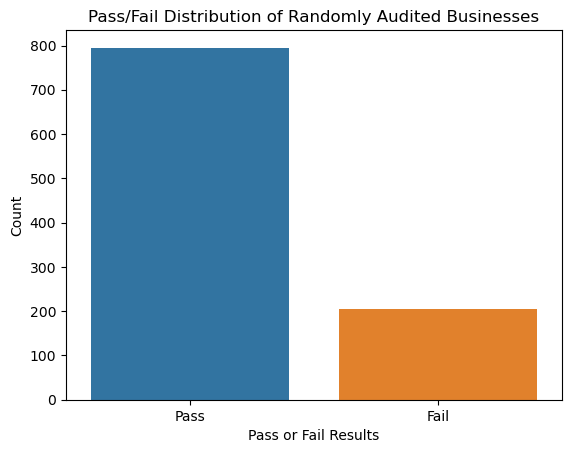

In [90]:
random_audit_y = np.random.choice(y.flatten(), 1000, replace=False)

# Create a new DataFrame with labels
df = pd.DataFrame({'Inspection_Result': random_audit_y.ravel()})
df['Label'] = df['Inspection_Result'].map({0: 'Pass', 1: 'Fail'})

# plot
sns.countplot(x='Inspection_Result', data=df)

# setting labels and title for clarity
plt.xticks(ticks=[0, 1], labels=['Pass', 'Fail'])
plt.xlabel('Pass or Fail Results')
plt.ylabel('Count')
plt.title('Pass/Fail Distribution of Randomly Audited Businesses')
plt.show()


We can clearly see that the predictive auditing approach detects far more failures than the random auditing approach. 

### Predict on 2014 inspection data

Use your favorite model to make predictions based on the features using the "Chicago Inspection 2014_updated.csv" file. Treat this as you would a test dataset. This means you will have to format the features (including removing some features and getting dummies) and the label (binarize and recode) in the same way you did the training data. (Remember the "Results" column is your label). You will then compare your predictions with the actual.

In [105]:
# Inspections Data 2014
chicago_inspections_2014 = pd.read_csv("data/Chicago Inspections 2014_updated.csv", 
                                      low_memory=False)

In [106]:
# data processing
# -----------
chicago_inspections_2014.drop(columns = ['AKA_Name', 
                                                 'License',
                                                'Address',
                                                'City',
                                                'State',
                                                'Zip',
                                                'Latitude',
                                                'Longitude',
                                                'Location',
                                                'ID',
                                                'LICENSE_ID',
                                                 'LICENSE_TERM_START_DATE',
                                                 'LICENSE_TERM_EXPIRATION_DATE',
                                                 'LICENSE_STATUS',
                                                'ACCOUNT_NUMBER',
                                                'LEGAL_NAME',
                                                'DOING_BUSINESS_AS_NAME',
                                                'ADDRESS',
                                                'CITY',
                                                'STATE',
                                                'ZIP_CODE',
                                                'WARD',
                                                'PRECINCT',
                                                'LICENSE_CODE',
                                                'BUSINESS_ACTIVITY_ID',
                                                'BUSINESS_ACTIVITY',
                                                'LICENSE_NUMBER',
                                                'LATITUDE',
                                                'LONGITUDE'],
                                     inplace = True)

chicago_inspections_2014.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

# Convert the Inspection Date to a datetime format
chicago_inspections_2014['Inspection_Date'] = pd.to_datetime(chicago_inspections_2014['Inspection_Date'], infer_datetime_format=True)  

# drop datetime info
# -----------
chicago_inspections_2014 = chicago_inspections_2014.dropna().drop(['Inspection_Date',
                                                                    'minDate',
                                                                    'maxDate'],
                                                                    axis = 1)

# process features
X_test2014 = chicago_inspections_2014.drop(columns = ['Results', 
                                                     'Facility_Type', 
                                                     'LICENSE_DESCRIPTION', 
                                                     'WARD_PRECINCT'])


# get dummies
X_test2014 = pd.get_dummies(X_test2014)

# process target 
y_test2014 = chicago_inspections_2014['Results']

# binarize the outcome variable 
# -----------
y_test2014 = y_test2014.replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
y_test2014 = lb_style.fit_transform(y_test2014)

# recode 0s and 1s so 1s are "Fail"
y_test2014 = np.where(y_test2014 == 1, 0 ,1)

In [ ]:
print(X_test2014.shape)
print(y_test2014.shape)

In [111]:
# predict 
# -----------
test_predictions = logit_model.predict(X_test2014)

# compare using accuracy 
test_accuracy = accuracy_score(y_test2014, test_predictions)
print("Accuracy:", test_accuracy)

Accuracy: 0.9001778003556007


We can see that the accuracy of of the logistic model predictions on the test data are fairly good (around 90%). 

In [112]:

# evaluate
# -----------

# evaluate using recall 
test_recall = recall_score(y_test2014, test_predictions)
print("Recall:", test_recall)

Recall: 0.7551020408163265


Our recall is not nearly as good as our accuracy (only 75%), probably because our outcome is unbalanced (it's much less likely for companies to fail an inspection than pass). This makes it more difficult for the model to correctly identify positive (and less likely) cases. 

### 5. Discussion Questions

1. Why do we need metrics beyond accuracy when using machine learning in the social sciences and public policy?

**In some cases, like this inspection problem, we might care a lot about avoiding either type 1 or type 2 error. Accuracy doesn't tell us anything about the kinds of errors we're making, but other metrics, like recall and precision, do. We might want to use recall when its more important to minimize our false negatives (as in this inspection problem), but in other cases, minimizing false positives is more important (i.e. decision-making around incarceration where it would be more important not to imprison an innocent person than to not imprison a guilty person) and precision should be used.**

2. Imagine that establishments learned about the algorithm being used to determine who gets audited and they started adjusting their behavior (and changing certain key features about themselves that were important for the prediction) to avoid detection. How could policymakers address this interplay between algorithmic decisionmaking and real world behavior?

**Policymakers and researchers should not rely on the same models or data for too long. Perhaps every five years or so models should be re-trained so as to uncover any shifts in feature importance due to changes establishments might make to avoid detection. Additionally, on-the-ground experts in the food inspection industry should remain aware of changes businesses might make that wouldn't be measured and communicate these changes to data collection experts. Data collectors could then incorporate missing features into their collection efforts.**